In [1]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

2024-05-05 16:35:35.261825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
train_data_path = './data/original/Training'
filepaths = []
labels = []

# Get all subdirectories in the training data path
folds = [f for f in os.listdir(train_data_path) if not f.startswith('.') and os.path.isdir(os.path.join(train_data_path, f))]

for fold in folds:
    f_path = os.path.join(train_data_path, fold)

    # Ensure it's a directory before processing
    if os.path.isdir(f_path):
        # Here, you could use the fold name as the label
        label = fold
        filelists = os.listdir(f_path)

        # Append each file with its corresponding label
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(label)

# Concat data paths with labels into a DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
assert len(Fseries) == len(Lseries), "Mismatch between filepaths and labels."
train_df = pd.concat([Fseries, Lseries], axis=1)

# Display the first few rows of the DataFrame
train_df.head()

,filepaths,label
0,./data/original/Training/pituitary/Tr-pi_0505.jpg,pituitary
1,./data/original/Training/pituitary/Tr-pi_0263.jpg,pituitary
2,./data/original/Training/pituitary/Tr-pi_0277.jpg,pituitary
3,./data/original/Training/pituitary/Tr-pi_1169.jpg,pituitary
4,./data/original/Training/pituitary/Tr-pi_0511.jpg,pituitary


In [8]:
train_data_path = './data/original/Testing'
filepaths = []
labels = []

# Get all subdirectories in the training data path
folds = [f for f in os.listdir(train_data_path) if not f.startswith('.') and os.path.isdir(os.path.join(train_data_path, f))]

for fold in folds:
    f_path = os.path.join(train_data_path, fold)

    # Ensure it's a directory before processing
    if os.path.isdir(f_path):
        # Here, you could use the fold name as the label
        label = fold
        filelists = os.listdir(f_path)

        # Append each file with its corresponding label
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(label)

# Concat data paths with labels into a DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
assert len(Fseries) == len(Lseries), "Mismatch between filepaths and labels."
test_df = pd.concat([Fseries, Lseries], axis=1)

# Display the first few rows of the DataFrame
test_df.head()

,filepaths,label
0,./data/original/Testing/pituitary/Te-pi_0233.jpg,pituitary
1,./data/original/Testing/pituitary/Te-pi_0227.jpg,pituitary
2,./data/original/Testing/pituitary/Te-pi_0019.jpg,pituitary
3,./data/original/Testing/pituitary/Te-pi_0031.jpg,pituitary
4,./data/original/Testing/pituitary/Te-pi_0025.jpg,pituitary


## Image preprocessing using data generator

In [9]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 1311 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


## Show sample from train data

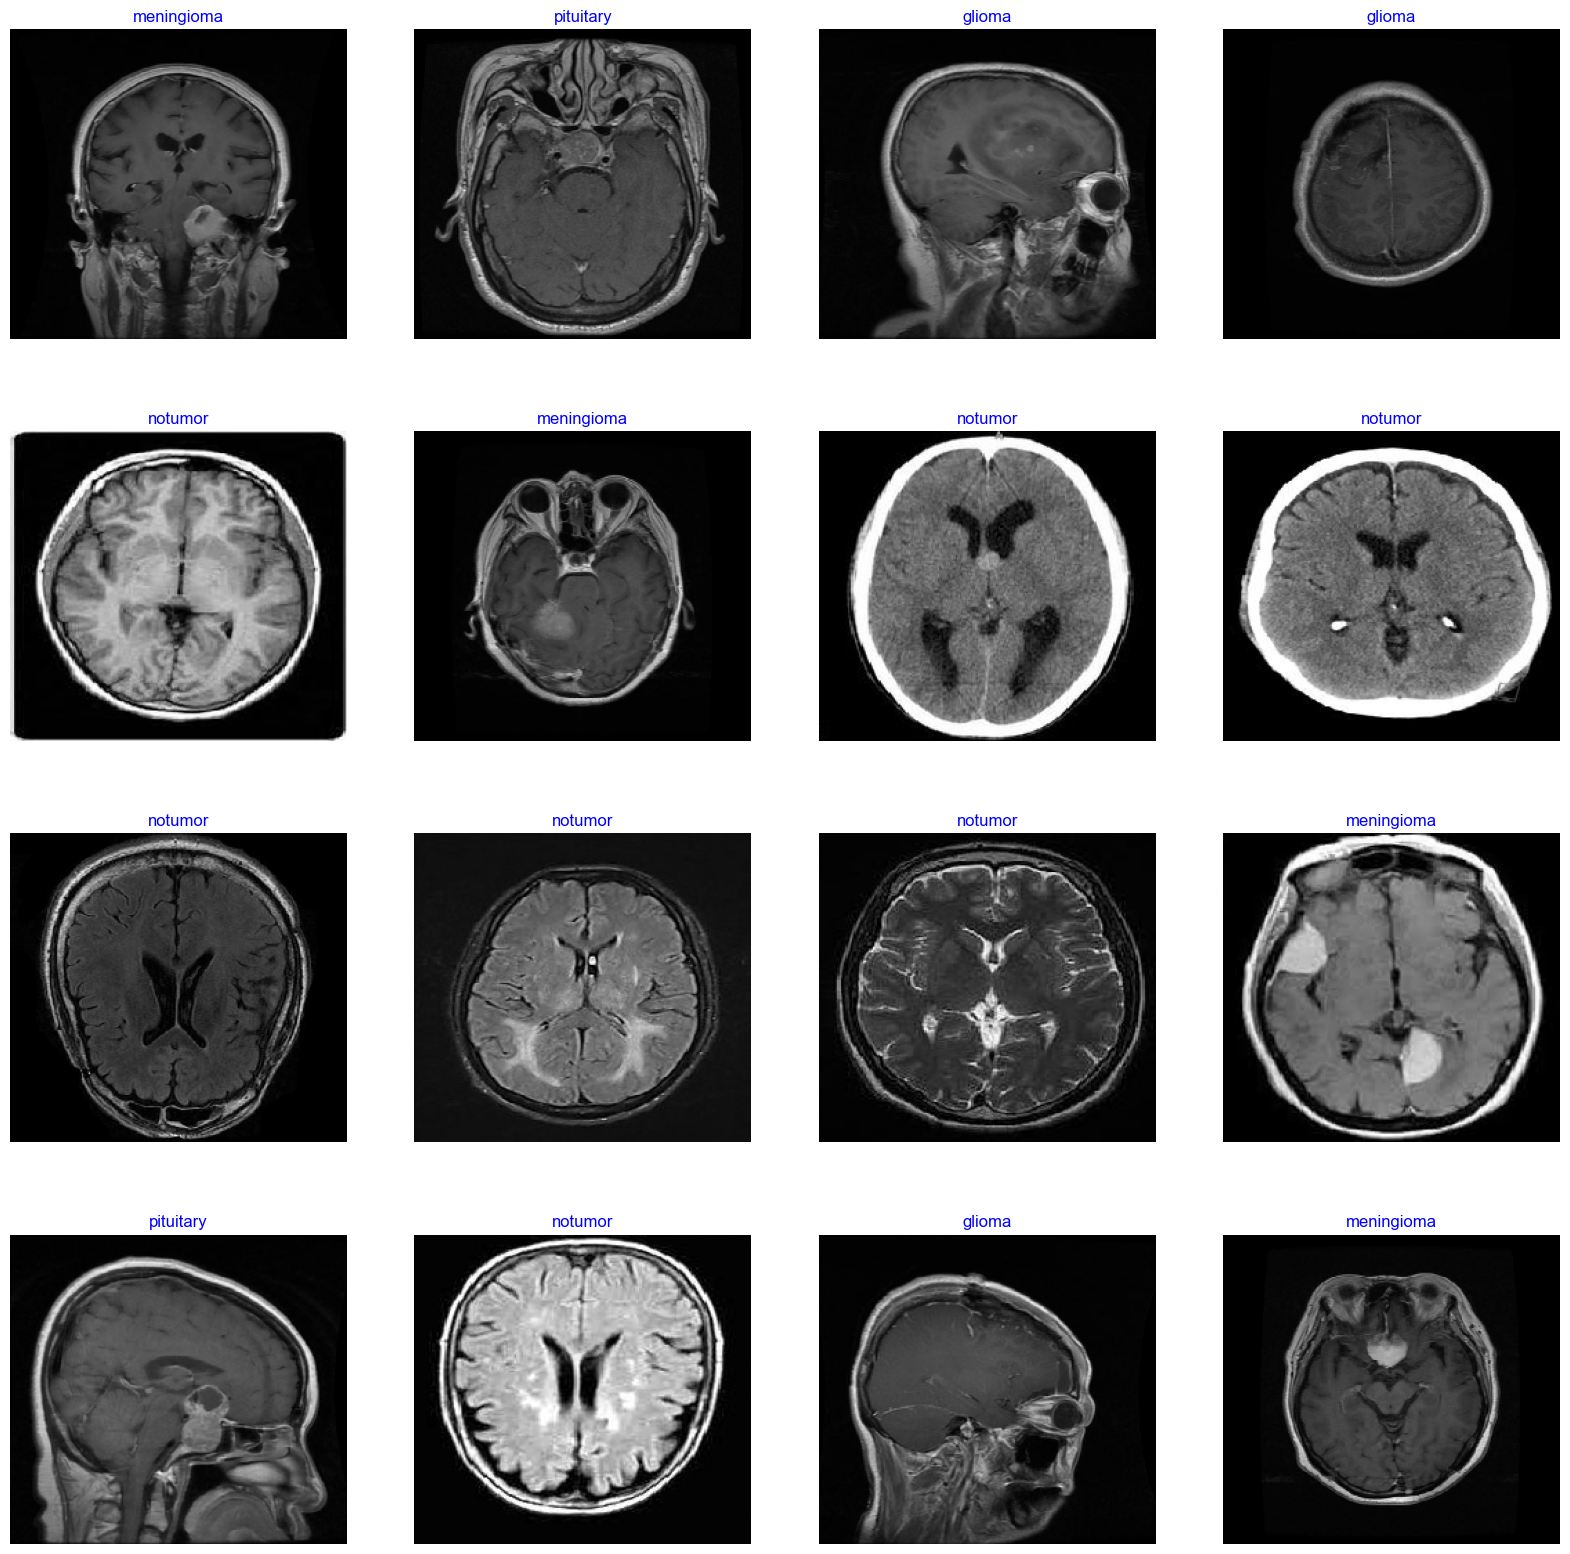

In [10]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

## Model Structure

In [12]:
#This architecture uses transfer learning by leveraging the pre-trained EfficientNetB3 model to extract features from images 
#and then adds custom fully connected layers for classification, aiming to classify images into multiple classes. 
#Regularization techniques like dropout and regularization penalties are employed to prevent overfitting during training.

img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

# EfficientNetB3 without the top layers (for feature extraction)
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)

# Custom classification layers with correct regularization keywords
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, kernel_regularizer=regularizers.l2(0.016),  # Correct keyword
          activity_regularizer=regularizers.l1(0.006),  # Correct keyword
          bias_regularizer=regularizers.l1(0.006),  # Correct keyword
          activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(256, kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.2, seed=75),
    Dense(num_class, activation='softmax')
])

# Compile the model
model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary to confirm correct construction
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

## Iterate

In [ ]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = test_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1176s 13s/step - accuracy: 0.3308 - loss: 31.6826 - val_accuracy: 0.3074 - val_loss: 19.9749
Epoch 2/10
32/82 ━━━━━━━━━━━━━━━━━━━━ 16:57 20s/step - accuracy: 0.2782 - loss: 16.8894

## Model Performance

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

## Model Evaluation

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
#valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

## Model Prediction

## Confusion Matrix and Classification Report

In [ ]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))